# Cart Pole with neural function approximator TF2
### Christian Igel, 2019

If you have suggestions for improvement, [let me know](mailto:igel@diku.dk).

I took inspiration from https://github.com/udacity/deep-learning/blob/master/reinforcement/Q-learning-cart.ipynb.

In [1]:
import gym

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
action_size = 2
state_size = 4

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Let's just test the environment first:

In [3]:
test_episodes = 10
for _ in range(test_episodes):
    R = 0
    state = env.reset()  # Environment starts in a random state, cart and pole are moving
    print("initial state:", state)
    while True:  # Environment sets "done" to true after 200 steps 
        # Uncomment the line below to watch the simulation
        # env.render()
        state, reward, done, info = env.step(env.action_space.sample()) # take a random action
        R += reward
        if done:
            print("return: ", R)
            env.reset()
            break

initial state: [ 0.02762808 -0.02371627 -0.01010676  0.03572369]
return:  14.0
initial state: [-0.01412401 -0.00438035  0.00329317  0.02733238]
return:  11.0
initial state: [-0.00178016  0.04981552  0.01295902 -0.0419306 ]
return:  12.0
initial state: [-0.00813216 -0.01081521 -0.03332785  0.01818648]
return:  14.0
initial state: [ 0.0416307   0.01266761 -0.03418146  0.03306596]
return:  11.0
initial state: [-0.02205869  0.0405169  -0.04732866 -0.00874136]
return:  21.0
initial state: [ 0.03805057 -0.02327617  0.03319597  0.02106177]
return:  11.0
initial state: [0.01707813 0.00938839 0.0257548  0.00098258]
return:  22.0
initial state: [-0.03655643 -0.01076983  0.0145503   0.02198126]
return:  15.0
initial state: [-0.00513509 -0.03844208 -0.04870138 -0.04599407]
return:  36.0


In [4]:
env.close()  # Closes the visualization window

Define *Q* network architecture:

In [5]:
class QNetwork(tf.keras.Model):
    def __init__(self, state_size=4, action_size=2, hidden_size=10, name='QNetwork'):
        super(QNetwork, self).__init__()
        self.fc1 = tf.keras.layers.Dense(hidden_size, activation='relu', use_bias=True)
        self.fc2 = tf.keras.layers.Dense(hidden_size, activation='relu', use_bias=True)
        self.fc3 = tf.keras.layers.Dense(action_size, activation=None, use_bias=True)
    def call(self, x):
        return self.fc3(self.fc2(self.fc1(x)))

Data structure for storing experiences:

In [6]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

Define basic constants:

In [7]:
train_episodes = 400           # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.005           # minimum exploration probability 
decay_rate = 0.001             # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 100               # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

Instantiate network:

In [8]:
mainQN = QNetwork(name='main', hidden_size=hidden_size)
mainQN.build(input_shape=(None, state_size))
print(mainQN.summary())

Model: "q_network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  320       
_________________________________________________________________
dense_1 (Dense)              multiple                  4160      
_________________________________________________________________
dense_2 (Dense)              multiple                  130       
Total params: 4,610
Trainable params: 4,610
Non-trainable params: 0
_________________________________________________________________
None


Do the *Q*-learning:

In [9]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(pretrain_length):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails, so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

In [10]:
learning_rate = 0.0001         # Q-network learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=0.01)

@tf.function
def compute_gradient(states, actions, targets, action_size=2):
    one_hot_actions = tf.one_hot(actions, action_size)
    with tf.GradientTape() as tape:
        output = mainQN(states)
        Q = tf.reduce_sum(tf.multiply(output, one_hot_actions), axis=1)
        loss = tf.math.reduce_mean(tf.square(Q - targets))
    return loss, tape.gradient(loss, mainQN.trainable_variables)

Now train with experiences:

In [11]:
rewards_list = []

step = 0
for ep in range(train_episodes):
    total_reward = 0
    t = 0
    state = env.reset()  # Reset and get initial state
    while t < max_steps:
        step += 1
        # Uncomment this next line to watch the training
        # env.render() 
            
        # Explore or exploit
        explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
        if explore_p > np.random.rand():
            # Make a random action
            action = env.action_space.sample()
        else:
            # Get action from Q-network
            Qs = mainQN(np.resize(state, (1, state_size)).astype(np.float32))
            action = np.argmax(Qs)
            
        # Take action, get new state and reward
        next_state, reward, done, _ = env.step(action)
    
        total_reward += reward
           
        if done:
            # Episode ends, so no next state
            next_state = np.zeros(state.shape)
            t = max_steps
                
            print('Episode: {}'.format(ep), 'Total reward: {}'.format(total_reward),
                  'Training loss: {:.4f}'.format(loss), 'Explore P: {:.4f}'.format(explore_p))
            rewards_list.append((ep, total_reward))
                
            # Add experience to memory
            memory.add((state, action, reward, next_state))
        else:
            # Add experience to memory
            memory.add((state, action, reward, next_state))
            state = next_state
            t += 1
            
        # Sample mini-batch from memory
        batch = memory.sample(batch_size)
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        rewards = np.array([each[2] for each in batch])
        next_states = np.array([each[3] for each in batch])
            
        # Train network           
        target_Qs = mainQN(next_states.astype(np.float32)).numpy()
            
        # Set target_Qs to 0 for states where episode ends
        episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
        target_Qs[episode_ends] = (0., 0.)
            
        # Compute target Q values   
        targets = rewards + gamma * np.max(target_Qs, axis=1)  # Max: Q-learning is off-policy & greedy 

        # Gradient-based update
        loss, gradients = compute_gradient(states.astype(np.float32), actions, targets.astype(np.float32))
        optimizer.apply_gradients(zip(gradients, mainQN.trainable_variables))

log_path = "/tmp/deep_Q_network"
mainQN.save_weights(log_path)

Episode: 0 Total reward: 17.0 Training loss: 1.0609 Explore P: 0.9832
Episode: 1 Total reward: 22.0 Training loss: 1.0621 Explore P: 0.9619
Episode: 2 Total reward: 12.0 Training loss: 1.0890 Explore P: 0.9505
Episode: 3 Total reward: 28.0 Training loss: 1.0588 Explore P: 0.9244
Episode: 4 Total reward: 20.0 Training loss: 1.0548 Explore P: 0.9062
Episode: 5 Total reward: 46.0 Training loss: 1.0314 Explore P: 0.8657
Episode: 6 Total reward: 29.0 Training loss: 1.0561 Explore P: 0.8411
Episode: 7 Total reward: 74.0 Training loss: 1.0863 Explore P: 0.7815
Episode: 8 Total reward: 71.0 Training loss: 1.0655 Explore P: 0.7282
Episode: 9 Total reward: 14.0 Training loss: 1.0651 Explore P: 0.7182
Episode: 10 Total reward: 26.0 Training loss: 1.0266 Explore P: 0.6999
Episode: 11 Total reward: 36.0 Training loss: 1.0417 Explore P: 0.6753
Episode: 12 Total reward: 24.0 Training loss: 1.1641 Explore P: 0.6594
Episode: 13 Total reward: 27.0 Training loss: 1.0755 Explore P: 0.6420
Episode: 14 Tota

Episode: 119 Total reward: 10.0 Training loss: 8.8294 Explore P: 0.1675
Episode: 120 Total reward: 10.0 Training loss: 20.3174 Explore P: 0.1659
Episode: 121 Total reward: 9.0 Training loss: 10.4323 Explore P: 0.1645
Episode: 122 Total reward: 9.0 Training loss: 10.2809 Explore P: 0.1630
Episode: 123 Total reward: 10.0 Training loss: 14.5799 Explore P: 0.1615
Episode: 124 Total reward: 10.0 Training loss: 23.2913 Explore P: 0.1599
Episode: 125 Total reward: 10.0 Training loss: 21.1204 Explore P: 0.1584
Episode: 126 Total reward: 10.0 Training loss: 7.0101 Explore P: 0.1568
Episode: 127 Total reward: 13.0 Training loss: 14.2922 Explore P: 0.1549
Episode: 128 Total reward: 11.0 Training loss: 7.8685 Explore P: 0.1532
Episode: 129 Total reward: 11.0 Training loss: 13.5430 Explore P: 0.1516
Episode: 130 Total reward: 10.0 Training loss: 20.1675 Explore P: 0.1501
Episode: 131 Total reward: 10.0 Training loss: 9.6325 Explore P: 0.1487
Episode: 132 Total reward: 33.0 Training loss: 13.3119 Ex

Episode: 232 Total reward: 184.0 Training loss: 3.9256 Explore P: 0.0051
Episode: 233 Total reward: 186.0 Training loss: 3.3394 Explore P: 0.0051
Episode: 234 Total reward: 168.0 Training loss: 11.1755 Explore P: 0.0051
Episode: 235 Total reward: 200.0 Training loss: 18.4670 Explore P: 0.0051
Episode: 236 Total reward: 173.0 Training loss: 7.0471 Explore P: 0.0051
Episode: 237 Total reward: 174.0 Training loss: 54.2775 Explore P: 0.0050
Episode: 238 Total reward: 190.0 Training loss: 3.6739 Explore P: 0.0050
Episode: 239 Total reward: 200.0 Training loss: 21.5240 Explore P: 0.0050
Episode: 240 Total reward: 200.0 Training loss: 15.0186 Explore P: 0.0050
Episode: 241 Total reward: 200.0 Training loss: 5.7265 Explore P: 0.0050
Episode: 242 Total reward: 200.0 Training loss: 14.8918 Explore P: 0.0050
Episode: 243 Total reward: 200.0 Training loss: 5.7049 Explore P: 0.0050
Episode: 244 Total reward: 200.0 Training loss: 30.0618 Explore P: 0.0050
Episode: 245 Total reward: 200.0 Training lo

Episode: 344 Total reward: 200.0 Training loss: 0.2668 Explore P: 0.0050
Episode: 345 Total reward: 200.0 Training loss: 21.1654 Explore P: 0.0050
Episode: 346 Total reward: 200.0 Training loss: 0.2571 Explore P: 0.0050
Episode: 347 Total reward: 200.0 Training loss: 0.2399 Explore P: 0.0050
Episode: 348 Total reward: 200.0 Training loss: 0.2978 Explore P: 0.0050
Episode: 349 Total reward: 200.0 Training loss: 0.2801 Explore P: 0.0050
Episode: 350 Total reward: 200.0 Training loss: 0.2273 Explore P: 0.0050
Episode: 351 Total reward: 200.0 Training loss: 56.9008 Explore P: 0.0050
Episode: 352 Total reward: 200.0 Training loss: 48.4167 Explore P: 0.0050
Episode: 353 Total reward: 200.0 Training loss: 6.5636 Explore P: 0.0050
Episode: 354 Total reward: 200.0 Training loss: 31.8980 Explore P: 0.0050
Episode: 355 Total reward: 200.0 Training loss: 0.3215 Explore P: 0.0050
Episode: 356 Total reward: 200.0 Training loss: 0.2865 Explore P: 0.0050
Episode: 357 Total reward: 200.0 Training loss:

Evaluate learning process and final policy:

In [12]:
# Moving average for smoothing plot
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0, 0.5, 'Total Reward')

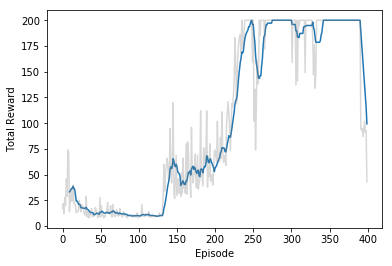

In [13]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

In [14]:
testQN = QNetwork(name='test', hidden_size=hidden_size)
testQN.build(input_shape=(None, state_size))
testQN.load_weights(log_path)

test_episodes = 10

for ep in range(test_episodes):
    state = env.reset()
    print("initial state:", state)
    R = 0
    while True:
        env.render() 
            
        # Get action from Q-network
        # Hm, the following line could be more elegant ...
        Qs = testQN(np.float32(np.resize(state, (1, state_size))))
        action = np.argmax(Qs)
            
        # Take action, get new state and reward
        next_state, reward, done, _ = env.step(action)
        R += reward
            
        if done:
            print("number of steps:", R)
            break
        else:
            state = next_state
                

initial state: [-0.0325887   0.03579323 -0.0167991  -0.03179098]
number of steps: 35.0
initial state: [-0.00491421 -0.04861907  0.04852777  0.03435305]
number of steps: 38.0
initial state: [-0.0373284   0.03572017 -0.03216222  0.00256773]
number of steps: 28.0
initial state: [ 0.0482177  -0.02838264  0.04230335  0.03683343]
number of steps: 35.0
initial state: [-0.0062584   0.0169086   0.02276069  0.00459129]
number of steps: 36.0
initial state: [ 0.04068825 -0.04142618  0.00656804  0.03761432]
number of steps: 36.0
initial state: [ 0.03311615 -0.03559329 -0.03074419 -0.03235361]
number of steps: 31.0
initial state: [-0.01756248 -0.04830539  0.04905984  0.03037402]
number of steps: 36.0
initial state: [-0.0024902   0.04219503  0.00342888 -0.0027845 ]
number of steps: 31.0
initial state: [ 0.0129798   0.01527522 -0.04913573  0.01069316]
number of steps: 25.0


In [15]:
env.close()